# Extraction of PS order parameter from the `.mpack` files of the saved models

In [1]:
import netket as nk
import numpy as np
import time
import json
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import jax
import flax
import optax
from sys import version as pyvers

print("Python version: {}".format(pyvers))
print("NetKet version: {}".format(nk.__version__))
print("NumPy version: {}".format(np.__version__))

Python version: 3.8.10 (default, Nov 26 2021, 20:14:08) 
[GCC 9.3.0]
NetKet version: 3.3.3
NumPy version: 1.20.3


In [2]:
"""lattice"""	
SITES    = 64            # 4, 8, 16, 20 ... number of vertices in a tile determines the tile shape 	
JEXCH1   = .2            # nn interaction	
JEXCH2   = 1            # nnn interaction	
H_Z      = 0             # magnetic field
USE_PBC = True
TOTAL_SZ = None            # 0, None ... restriction of Hilbert space	
"""machine learning"""	
SAMPLER = 'local'       # 'local' = MetropolisLocal, 'exchange' = MetropolisExchange, 'exact' = ExactSampler
MACHINE = 'RBM'         # 'RBM', 'sRBM'
DTYPE = np.complex128   # type of weights in neural network
ALPHA = 8              # N_hidden / N_visible	
ETA   = .01            # learning rate (0.01 usually works)	
SIGMA = .01             # variance of parameters during initialization
SAMPLES = 1000	#!!! zero added!!!
NUM_ITER = 1000
N_PRE_ITER = 100        # number of iteration before checking for convergence to speed up the process if the model is already pre-trained
STEPS = np.arange(0.0,1.21,step=0.1)

In [3]:
from lattice_and_ops import Lattice
lattice = Lattice(SITES)

if not USE_PBC and SITES != 16:
    raise Exception("Non-PBC are implemented only for 4x4 lattice!!!")

# Construction of custom graph according to tiled lattice structure defined in the Lattice class.
edge_colors = []
for node in range(SITES):
    if USE_PBC or not node in [3,7,11,15]:
        edge_colors.append([node,lattice.rt(node), 1])  # horizontal connections
    if USE_PBC or not node in [12,13,14,15]:
        edge_colors.append([node,lattice.bot(node), 1]) # vertical connections
    row, column = lattice.position(node)
    
    SS_color = 3 if not USE_PBC and node in [3,7,4,12,13,14,15] else 2
    if column%2 == 0:
        if row%2 == 0:
            edge_colors.append([node,lattice.lrt(node),SS_color]) # diagonal bond
        else:
            edge_colors.append([node,lattice.llft(node),SS_color]) # diagonal bond

g = nk.graph.Graph(edges=edge_colors) #,n_nodes=3)
N = g.n_nodes

hilbert = nk.hilbert.Spin(s=.5, N=g.n_nodes, total_sz=TOTAL_SZ)

In [4]:
from lattice_and_ops import HamOps
ho = HamOps()
# H_Z = .5
ha_1 = nk.operator.GraphOperator(hilbert, graph=g, bond_ops=ho.bond_operator(JEXCH1,JEXCH2, h_z=H_Z, use_MSR=False), bond_ops_colors=ho.bond_color)
ha_2 = nk.operator.GraphOperator(hilbert, graph=g, bond_ops=ho.bond_operator(JEXCH1,JEXCH2, h_z=H_Z, use_MSR=True), bond_ops_colors=ho.bond_color)


In [5]:
from lattice_and_ops import Operators
ops = Operators(lattice,hilbert,ho.mszsz,ho.exchange)

In [6]:
g.edges(color=1)

/home/mezic/.local/lib/python3.8/site-packages/netket/graph/graph.py:160: FutureWarning: The color option has been split into return_color and filter_color.
  warn_deprecation(


[(0, 1),
 (0, 8),
 (1, 2),
 (1, 9),
 (2, 3),
 (2, 10),
 (3, 4),
 (3, 11),
 (4, 5),
 (4, 12),
 (5, 6),
 (5, 13),
 (6, 7),
 (6, 14),
 (0, 7),
 (7, 15),
 (8, 9),
 (8, 16),
 (9, 10),
 (9, 17),
 (10, 11),
 (10, 18),
 (11, 12),
 (11, 19),
 (12, 13),
 (12, 20),
 (13, 14),
 (13, 21),
 (14, 15),
 (14, 22),
 (8, 15),
 (15, 23),
 (16, 17),
 (16, 24),
 (17, 18),
 (17, 25),
 (18, 19),
 (18, 26),
 (19, 20),
 (19, 27),
 (20, 21),
 (20, 28),
 (21, 22),
 (21, 29),
 (22, 23),
 (22, 30),
 (16, 23),
 (23, 31),
 (24, 25),
 (24, 32),
 (25, 26),
 (25, 33),
 (26, 27),
 (26, 34),
 (27, 28),
 (27, 35),
 (28, 29),
 (28, 36),
 (29, 30),
 (29, 37),
 (30, 31),
 (30, 38),
 (24, 31),
 (31, 39),
 (32, 33),
 (32, 40),
 (33, 34),
 (33, 41),
 (34, 35),
 (34, 42),
 (35, 36),
 (35, 43),
 (36, 37),
 (36, 44),
 (37, 38),
 (37, 45),
 (38, 39),
 (38, 46),
 (32, 39),
 (39, 47),
 (40, 41),
 (40, 48),
 (41, 42),
 (41, 49),
 (42, 43),
 (42, 50),
 (43, 44),
 (43, 51),
 (44, 45),
 (44, 52),
 (45, 46),
 (45, 53),
 (46, 47),
 (46, 54)

In [7]:
machine_1 = nk.models.RBM(dtype=DTYPE, alpha=ALPHA)
machine_2 = nk.models.RBM(dtype=DTYPE, alpha=ALPHA)
sampler_1 = nk.sampler.MetropolisLocal(hilbert=hilbert)
sampler_2 = nk.sampler.MetropolisLocal(hilbert=hilbert)
vs_1 = nk.vqs.MCState(sampler_1 , machine_1 , n_samples=SAMPLES)
vs_2 = nk.vqs.MCState(sampler_2 , machine_2 , n_samples=SAMPLES)

/home/mezic/.local/lib/python3.8/site-packages/netket/vqs/mc/mc_state/state.py:58: UserWarning: n_samples=1000 (1000 per MPI rank) does not divide n_chains=16, increased to 1008 (1008 per MPI rank)
  warnings.warn(


In [8]:
import netket.experimental

In [9]:
#ops.m_sSquared_slow_MSR(vs_2) 

## printed results
```
0.0 -0.144+0.000j ± 0.015 [σ²=0.133, R̂=1.2991] 0.085-0.000j ± 0.016 [σ²=0.158, R̂=1.3787] (DeviceArray(0.00172497+6.65161989e-05j, dtype=complex128), DeviceArray(3376.56646065, dtype=float64))
0.1 -0.099-0.001j ± 0.019 [σ²=0.215, R̂=1.3848] -0.341-0.000j ± 0.019 [σ²=0.225, R̂=1.3732] (DeviceArray(0.00885071-0.00018805j, dtype=complex128), DeviceArray(3157.0675619, dtype=float64))
0.2 0.000-0.000j ± 0.021 [σ²=0.251, R̂=1.4115] -0.166-0.001j ± 0.024 [σ²=0.852, R̂=1.0901] (DeviceArray(0.00541964-0.000387j, dtype=complex128), DeviceArray(6395.69501834, dtype=float64))
0.30000000000000004 1.158e-12-2.723e-12j ± 8.025e-14 [σ²=4.067e-24, R̂=1.3838] -0.180+0.011j ± 0.029 [σ²=0.933, R̂=1.1286] (DeviceArray(0.00795699+0.00056182j, dtype=complex128), DeviceArray(17055.70577887, dtype=float64))
0.4 -0.212+0.001j ± 0.017 [σ²=0.168, R̂=1.3601] -0.969+0.021j ± 0.023 [σ²=0.382, R̂=1.1419] (DeviceArray(0.10224766+0.00048891j, dtype=complex128), DeviceArray(10945.93731569, dtype=float64))
0.5 -0.199+0.001j ± 0.016 [σ²=0.160, R̂=1.3908] -0.867+0.001j ± 0.021 [σ²=0.389, R̂=1.0784] (DeviceArray(0.14169473-0.00023402j, dtype=complex128), DeviceArray(20447.6639892, dtype=float64))
0.6000000000000001 -0.034-0.000j ± 0.012 [σ²=0.090, R̂=1.3479] 0.001+0.001j ± 0.035 [σ²=1.667, R̂=1.0048] (DeviceArray(0.4918257+0.00027085j, dtype=complex128), DeviceArray(24846.6525526, dtype=float64))
0.7000000000000001 -0.094+0.002j ± 0.015 [σ²=0.193, R̂=1.1125] 0.074+0.003j ± 0.038 [σ²=2.007, R̂=1.0015] (DeviceArray(0.53392735+8.26162773e-05j, dtype=complex128), DeviceArray(25209.21527894, dtype=float64))
0.8 -0.005-0.012j ± 0.032 [σ²=1.658, R̂=1.0048] 0.099-0.001j ± 0.040 [σ²=1.837, R̂=1.0109] (DeviceArray(0.55290233-0.00017959j, dtype=complex128), DeviceArray(22041.68871786, dtype=float64))
0.9 0.054+0.002j ± 0.039 [σ²=1.961, R̂=1.0038] 0.057-0.002j ± 0.045 [σ²=1.966, R̂=1.0088] (DeviceArray(0.58979722+0.00075758j, dtype=complex128), DeviceArray(23765.34066292, dtype=float64))
1.0 0.016+0.020j ± 0.041 [σ²=1.332, R̂=1.0446] 0.047+0.001j ± 0.044 [σ²=1.836, R̂=1.0151] (DeviceArray(0.61449647+0.00161031j, dtype=complex128), DeviceArray(24261.84245778, dtype=float64))
1.1 -0.011-0.014j ± 0.038 [σ²=1.654, R̂=1.0142] 0.011+0.001j ± 0.036 [σ²=1.362, R̂=1.0081] (DeviceArray(0.60124403-0.00031234j, dtype=complex128), DeviceArray(21915.27878002, dtype=float64))
1.2000000000000002 0.055-0.001j ± 0.041 [σ²=1.880, R̂=1.0133] 0.089+0.001j ± 0.047 [σ²=1.957, R̂=1.0237] (DeviceArray(0.59136129+0.00115541j, dtype=complex128), DeviceArray(21983.83604879, dtype=float64))```

In [14]:
STEPS = [.71] #np.arange(0.71,0.89,step=0.02) #[0,0.5,0.8] #[0.2,0.9]

In [15]:
for i in STEPS:
    # loaded_variables_1 = nk.experimental.vqs.variables_from_file("resurrection/RBM64_"+"{:4.2f}".format(i)+"_0.mpack",vs_1.variables)
    loaded_variables_1 = nk.experimental.vqs.variables_from_file("paper_data/RBM64None_"+str(i)+"_0.mpack",vs_1.variables)
    # loaded_variables_2 = nk.experimental.vqs.variables_from_file("resurrection/RBM64_"+"{:3.2f}".format(i)+"_1.mpack",vs_2.variables)
    vs_1.variables = loaded_variables_1
    # vs_2.variables = loaded_variables_2
    # the evaluation m_sSquared_slow_MSR for 8x8 lattice takes 6 min on my CPU
    # print(i,vs_1.expect(ops.m_plaquette_op))#,vs_2.expect(ops.m_plaquette_op_MSR),ops.m_sSquared_slow_MSR(vs_2))
    PS_landscape = np.zeros((8,8))
    for j in range(8):
        for k in range(8):
            PS_landscape[j,k] = vs_1.expect(ops.Q_r(j*8+k,False)).mean.real

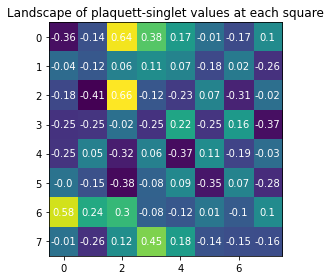

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(PS_landscape)

# Loop over data dimensions and create text annotations.
for i in range(8):
    for j in range(8):
        text = ax.text(j, i, round(PS_landscape[i, j],2), ha="center", va="center", color="w")

ax.set_title("Landscape of plaquett-singlet values at each square")
fig.tight_layout()
plt.show()

0.78 -0.644+0.002j ± 0.021 [σ²=0.502, R̂=1.0347]
0.76 0.332-0.017j ± 0.045 [σ²=1.367, R̂=1.1754]
0.74 0.055-0.003j ± 0.042 [σ²=1.383, R̂=1.0896]

In [ ]:
[Đđ]{df}

SyntaxError: invalid syntax (3005079556.py, line 1)

In [ ]:
sum_of_plaquettes = 0
for i in [1,3,5,7,17,19,21,23,33,35,37,39,49,51,53,55]:
    sum_of_plaquettes += PS_landscape[lattice.position(i)]
for i in [8,10,12,14,24,26,28,30,40,42,44,46,56,58,60,62]:
    sum_of_plaquettes -= PS_landscape[lattice.position(i)]
print(sum_of_plaquettes/16)

0.2948925842124


In [ ]:
ops.PS_order_full(vs_1)

DeviceArray(0.29489258, dtype=float64)

## Extraction of correct errorbars from KFES

In [ ]:
H_Z = 0
for JEXCH1 in STEPS[1:]:
    loaded_variables_1 = nk.experimental.vqs.variables_from_file("resurrection/RBM64_"+str(round(JEXCH1,1))+"_0.mpack",vs_1.variables) #SS_16j1=
    loaded_variables_2 = nk.experimental.vqs.variables_from_file("resurrection/RBM64_"+str(round(JEXCH1,1))+"_1.mpack",vs_2.variables)
    vs_1.variables = loaded_variables_1
    vs_2.variables = loaded_variables_2
    ha_1 = nk.operator.GraphOperator(hilbert, graph=g, bond_ops=ho.bond_operator(JEXCH1,JEXCH2, h_z=H_Z, use_MSR=False), bond_ops_colors=ho.bond_color)
    ha_2 = nk.operator.GraphOperator(hilbert, graph=g, bond_ops=ho.bond_operator(JEXCH1,JEXCH2, h_z=H_Z, use_MSR=True), bond_ops_colors=ho.bond_color)
    en_1 = vs_1.expect(ha_1)
    en_2 = vs_2.expect(ha_2)
    print(JEXCH1,en_1.mean.real, en_1.error_of_mean, en_2.mean.real, en_2.error_of_mean)
    # the evaluation m_sSquared_slow_MSR for 8x8 lattice takes 6 min on my CPU
    # print(i,vs_1.expect(ops.m_plaquette_op),vs_2.expect(ops.m_plaquette_op_MSR),ops.m_sSquared_slow_MSR(vs_2))

0.9 -126.40209783136396 0.13933272582813036 -128.98168843676436 0.17169911452398912


In [ ]:
STEPS = np.array([0.62,0.64,0.66,0.68,0.72,0.74,0.76,0.78])

In [ ]:
vs_1.estimate(ops.m_plaquette_op)

AttributeError: 'MCState' object has no attribute 'estimate'

In [ ]:
print(vs_1.expect(ops.m_plaquette_op),vs_2.expect(ops.m_plaquette_op_MSR),ops.m_sSquared_slow_MSR(vs_2))

-0.0201-0.0093j ± 0.0083 [σ²=0.1968, R̂=0.9997] -0.062+0.000j ± 0.026 [σ²=1.991, R̂=1.0008] (DeviceArray(1.0295763-2.37662473e-06j, dtype=complex128), DeviceArray(8182.94793354, dtype=float64))
